# Visualizing the Structure of Embeddings via dimensionality reduction

See `configs/config.yaml` for selected model, layer_idx and other parameters.


Sidenote: We'll denote tensor shapes via suffixes.
- B: Batch
- T: Time / Sequence position / context length
- D: Model embedding dimension

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.cache_llm import load_labeled_acts
from sklearn.decomposition import PCA
import torch as th
from src.config import load_config, Config
import matplotlib.pyplot as plt

/home/can/feature_zoo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Days of the Week


In [7]:
cfg = load_config()

# cfg.data.name = "days_filtered"
# cfg.data.fixed_context_length = None

cfg.exp.sequence_aggregation_method = "final"
cfg.exp.num_pca_components = 10

cfg

Config(
  env=EnvironmentConfig(
    dtype=torch.bfloat16
    device='cuda'
    hf_cache_dir=PosixPath('/home/can/models')
    texts_dir='data/texts'
    tokens_dir='data/tokens'
    activations_dir='data/activations'
    sae_dir='data/trained_saes'
    debug=False
  )
  data=DataConfig(
    name='days_filtered'
    fixed_context_length=5
  )
  llm=LLMConfig(
    name='gpt2'
    hf_name='openai-community/gpt2'
    layer_idx=8
    batch_size=100
    quantization_bits=None
  )
  sae=SAEConfig(
    llm_name='gpt2'
    llm_layer_idx=6
    arch='relu'
    batch_size=32
    act_scaling_factor=1.0
  )
  filter=FilterConfig(
    corpus='HuggingFaceFW/fineweb'
    regex_file='days'
    num_occurences=20
    min_char_count=50
  )
  exp=ExperimentConfig(
    sequence_aggregation_method='final'
    num_pca_components=10
  )
)

In [8]:
return_dict = load_labeled_acts(cfg, force_recompute=True)

SAE Cache: 100%|██████████| 5/5 [00:00<00:00, 367.14it/s]


In [ ]:
labels = return_dict["labels"]
texts = return_dict["texts"]

for i, (l, t) in enumerate(zip(labels, texts)):
    print(f"\n{l}: {t}")
    if i >= 2:
        break


monday: <|endoftext|> AP poll heading into Monday

monday: <|endoftext|> show is streamed every Monday

monday: <|endoftext|>am-6pm Monday


In [10]:
def pca_transform(cfg: Config, act_BD: th.Tensor) -> th.tensor:
    assert len(act_BD.shape) == 2
    EPS = 1e-8
    act_normalized_BD = act_BD / (act_BD.norm(dim=-1, keepdim=True) + EPS)
    if isinstance(act_normalized_BD, th.Tensor):
        act_normalized_BD = act_normalized_BD.cpu().detach().float().numpy()

    pca = PCA(n_components=cfg.exp.num_pca_components)
    act_pca_BD = pca.fit_transform(act_normalized_BD)

    return act_pca_BD

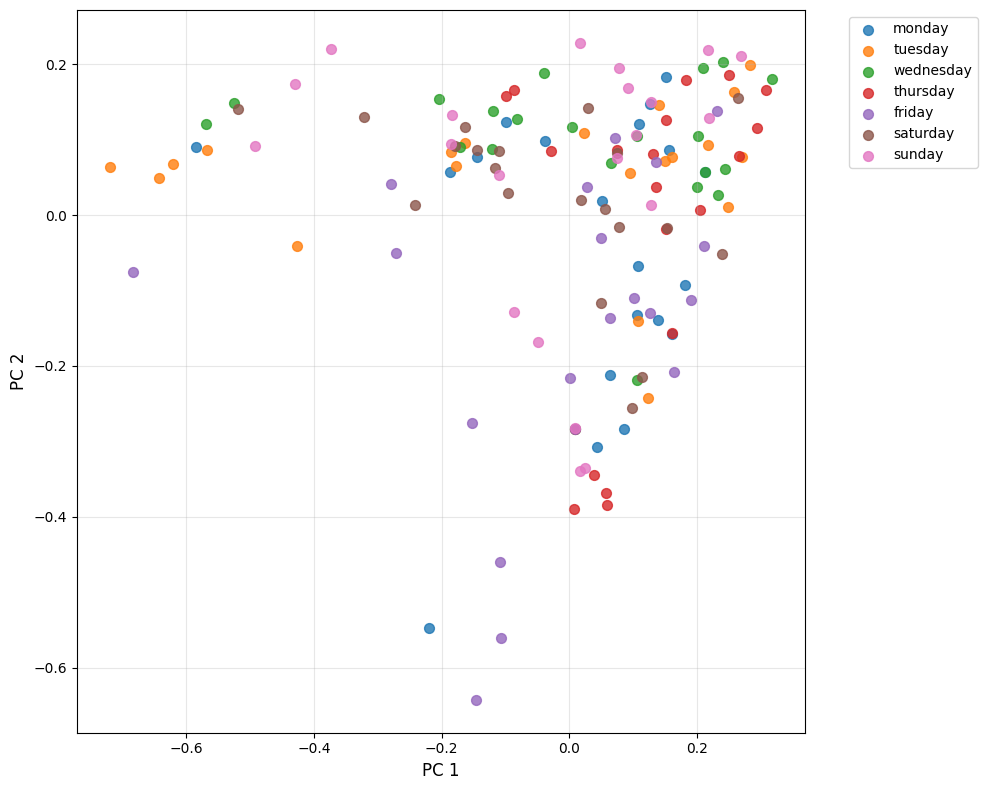

In [11]:
def plot_pca(act_pca_BD, labels, x_pca_idx = 0, y_pca_idx = 1):
    if isinstance(act_pca_BD, th.Tensor):
        act_pca_BD = act_pca_BD.cpu().detach().float().numpy()

    unique_labels = list(dict.fromkeys(labels))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

    # Create a custom discrete colorscale based on matplotlib's tab10
    tab10_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot each label with a different color
    for label in unique_labels:
        mask = [l == label for l in labels]
        idx = label_to_idx[label]
        color = tab10_colors[idx % len(tab10_colors)]
        ax.scatter(act_pca_BD[mask, x_pca_idx], act_pca_BD[mask, y_pca_idx], 
                label=label, color=color, alpha=0.8, s=50)

    ax.set_xlabel(f'PC {x_pca_idx}', fontsize=12)
    ax.set_ylabel(f'PC {y_pca_idx}', fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


act_PCA_BD = pca_transform(cfg, return_dict["recons_BD"])
plot_pca(
    act_PCA_BD, 
    return_dict["labels"],
    x_pca_idx=1,
    y_pca_idx=2
)

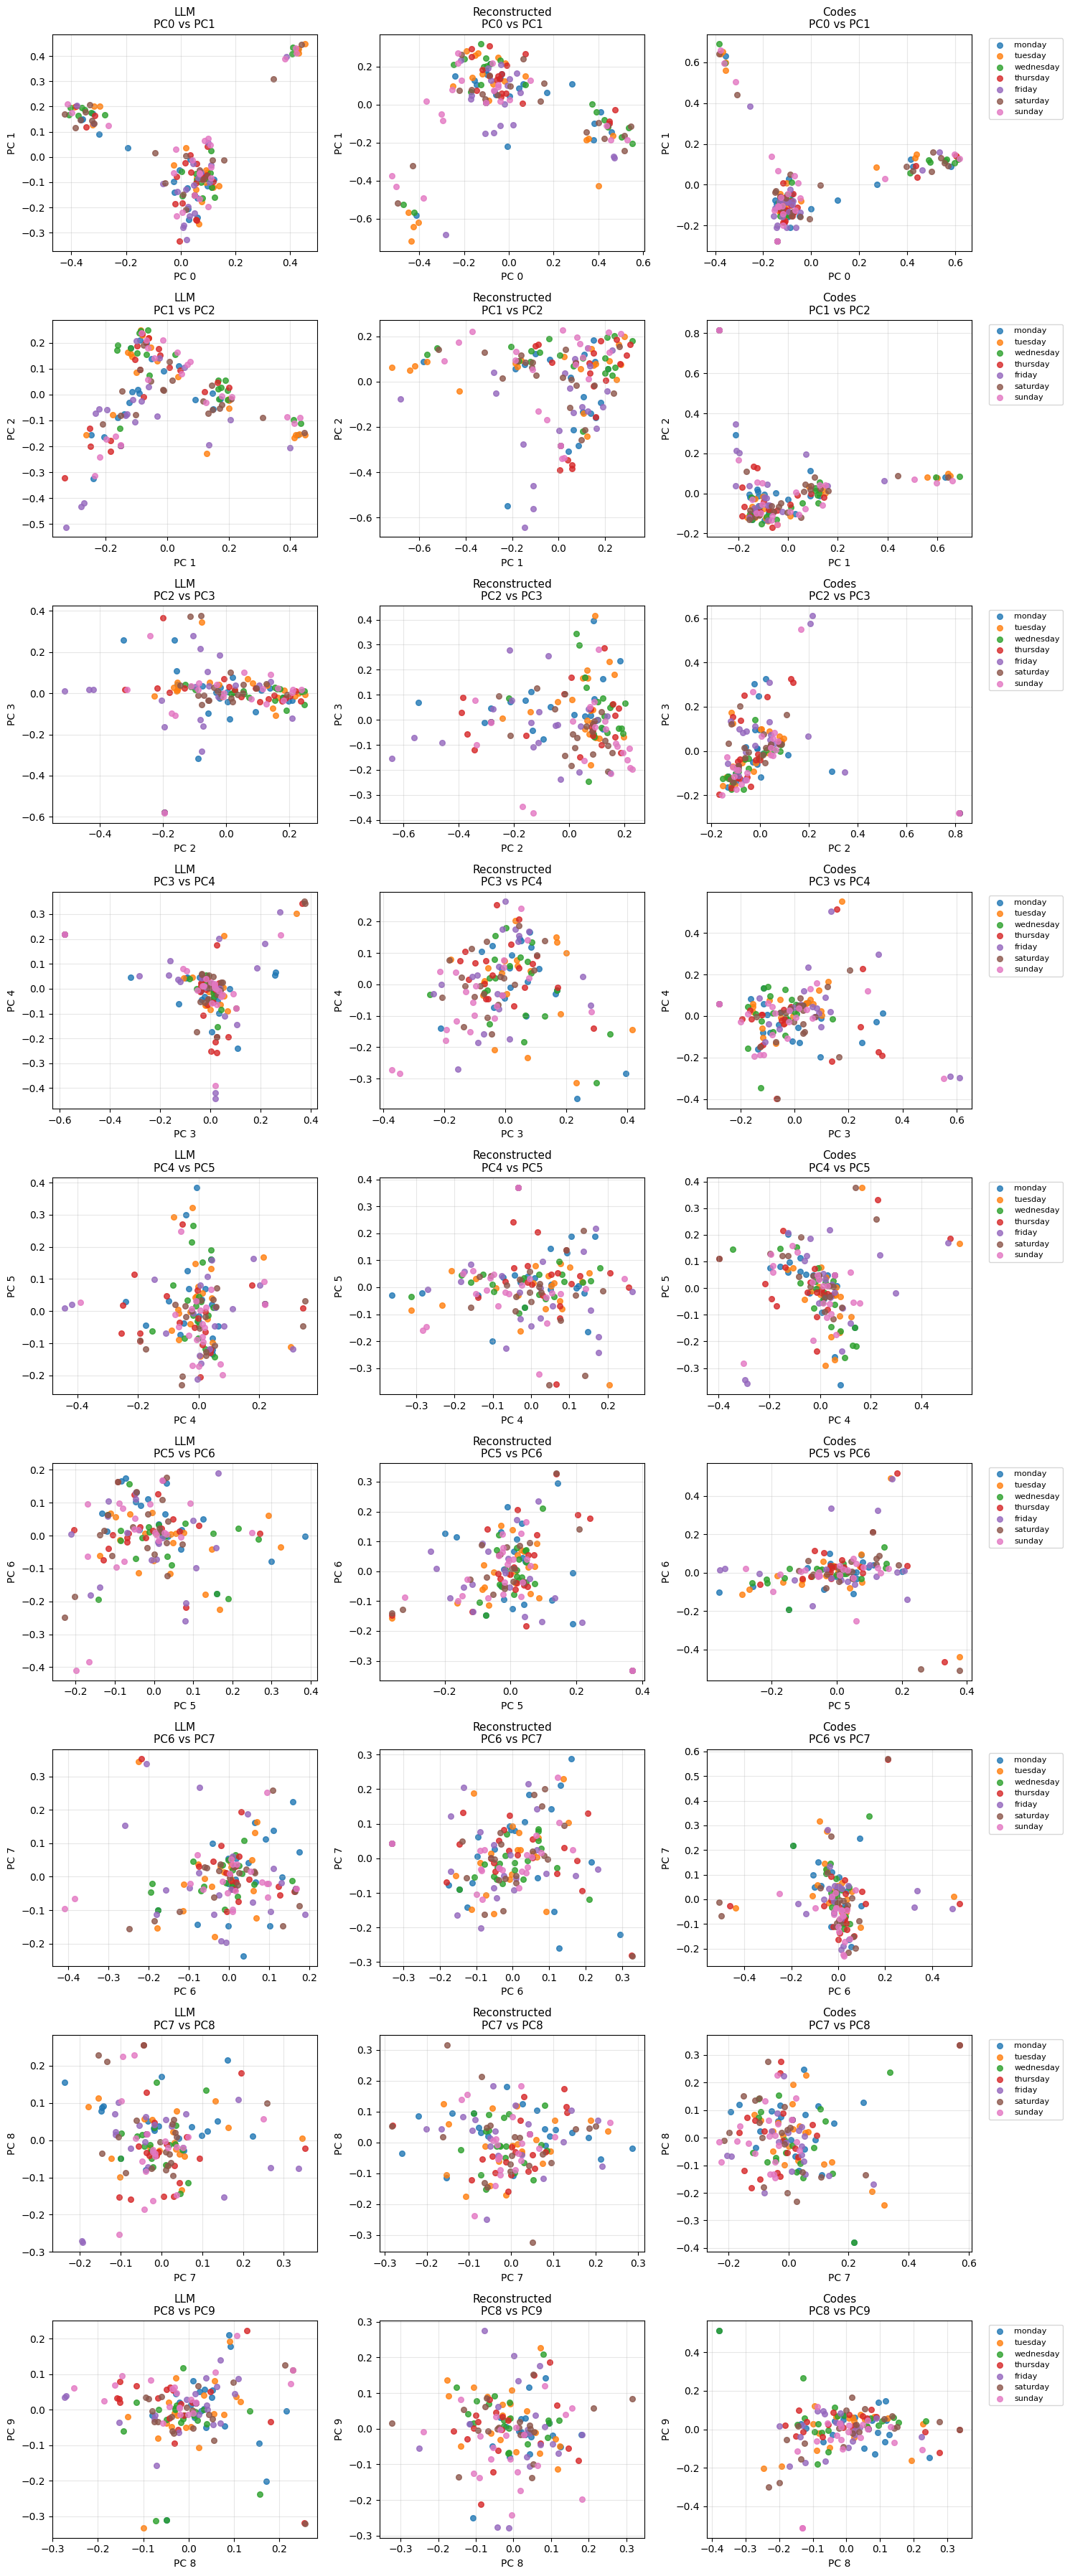

In [12]:
# Make another plot with multiple subplots. Each individual like plot_pca above 
# columns: activations types [llm_BD, recons_BD, pred_codes_BD, novel_codes_BD]
# Rows: pca components [0v1, 1v2, 2v3]

# Prepare activation data
activations = {
    'LLM': return_dict["llm_BD"],
    'Reconstructed': return_dict["recons_BD"],
}
if cfg.sae.arch == "temporal":
    activations['Predicted Codes'] = return_dict["pred_codes_BD"]
    activations['Novel Codes'] = return_dict["novel_codes_BD"]
else:
    activations['Codes'] = return_dict["codes_BD"]

# Handle case where we might have BTD tensors instead of BD
for key, val in activations.items():
    if val is not None and val.ndim == 3:  # BTD tensor
        # Use final timestep to get BD
        activations[key] = val[:, -1, :]

# Apply PCA transformation to each activation type
pca_results = {}
for name, act in activations.items():
    if act is not None:
        pca_results[name] = pca_transform(cfg, act)

# Define PC pairs for rows
pc_pairs = [(i, i+1) for i in range(cfg.exp.num_pca_components - 1)]

# Create subplot grid: 3 rows (PC pairs) x 4 columns (activation types)
fig, axes = plt.subplots(len(pc_pairs), len(activations), figsize=(len(activations)*5, len(pc_pairs)*4))

# Color setup
unique_labels = list(dict.fromkeys(labels))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
tab10_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Plot each combination
for row_idx, (pc_x, pc_y) in enumerate(pc_pairs):
    for col_idx, (act_name, act_pca_BD) in enumerate(pca_results.items()):
        ax = axes[row_idx, col_idx]
        
        # Plot each label with different color
        for label in unique_labels:
            mask = [l == label for l in labels]
            idx = label_to_idx[label]
            color = tab10_colors[idx % len(tab10_colors)]
            ax.scatter(act_pca_BD[mask, pc_x], act_pca_BD[mask, pc_y], 
                      label=label, color=color, alpha=0.8, s=30)
        
        # Set labels and title
        ax.set_xlabel(f'PC {pc_x}', fontsize=10)
        ax.set_ylabel(f'PC {pc_y}', fontsize=10)
        ax.set_title(f'{act_name}\nPC{pc_x} vs PC{pc_y}', fontsize=11)
        ax.grid(True, alpha=0.3)
        
        # Only show legend on the rightmost column
        if col_idx == len(pca_results) - 1:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# import json
# import plotly.graph_objs as go

# unique_labels = list(dict.fromkeys(labels))
# label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
# label_indices = [label_to_idx[label] for label in labels]

# # Create a custom discrete colorscale based on matplotlib's tab10
# tab10_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
#                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# num_labels = len(unique_labels)
# colorscale = [[i / (num_labels - 1) if num_labels > 1 else 0, tab10_colors[i % len(tab10_colors)]] 
#               for i in range(num_labels)]

# customdata = list(zip(labels, texts))

# fig = go.Figure(
#     data=[
#         go.Scatter3d(
#             x=act_pca_BD[:, 0],
#             y=act_pca_BD[:, 1],
#             z=act_pca_BD[:, 2],
#             mode="markers",
#             customdata=customdata,
#             hovertemplate="Label: %{customdata[0]}<br>Input: %{customdata[1]}<extra></extra>",
#             marker=dict(
#                 size=6,
#                 color=label_indices,
#                 colorscale=colorscale,
#                 opacity=0.8,
#                 showscale=True,
#                 colorbar=dict(
#                     title="Label",
#                     tickmode="array",
#                     tickvals=list(range(len(unique_labels))),
#                     ticktext=unique_labels,
#                 ),
#             ),
#         )
#     ]
# )
# fig.update_layout(
#     scene=dict(
#         xaxis_title="PC 1",
#         yaxis_title="PC 2",
#         zaxis_title="PC 3"
#     ),
#     margin=dict(l=0, r=0, b=0, t=30),
#     title="PCA 3D Scatter of Activations"
# )
# fig.show()
